<a href="https://colab.research.google.com/github/PuchToTalk/Unicef-challenge/blob/main/UNICEF_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import folium
from folium.plugins import HeatMap
import zipfile
import os


# prompt: mount on google drive
from google.colab import drive
drive.mount('/content/drive')

# base directory
base_dir = "/content/drive/My Drive/MVA/UNICEF/giga_hiring_challenge/"

# working directory
base_path = "/content/drive/My Drive/MVA/UNICEF/giga_hiring_challenge/mobility_4_test/"
os.chdir(base_path)

# result directory
output_dir = os.path.join(base_dir, "output")
os.makedirs(output_dir, exist_ok=True)
print(f"Output folder created (or already exists) at: {output_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Output folder created (or already exists) at: /content/drive/My Drive/MVA/UNICEF/giga_hiring_challenge/output


# Initialization

## Data Cleaning

In [ ]:
# List all CSV files
csv_files = sorted([file for file in os.listdir() if file.endswith('.csv')])
print("CSV Files Found:", csv_files)


CSV Files Found: ['day1_0000.csv', 'day1_0800.csv', 'day1_1600.csv', 'day2_0000.csv', 'day2_0800.csv', 'day2_1600.csv', 'day3_0000.csv', 'day3_0800.csv', 'day3_1600.csv', 'day4_0000.csv', 'day4_0800.csv', 'day4_1600.csv', 'day5_0000.csv', 'day5_0800.csv', 'day5_1600.csv', 'day6_0000.csv', 'day6_0800.csv', 'day6_1600.csv', 'day7_0000.csv', 'day7_0800.csv', 'day7_1600.csv']


## Concatening all 21 datasets into one unique dataset

In [ ]:
# Loading
data_list = []
for file in csv_files:
    temp_df = pd.read_csv(file)
    temp_df['time_window'] = file.split('.')[0]  # Extract time_window from its name
    data_list.append(temp_df)

# Combine into a single DataFrame
df = pd.concat(data_list, ignore_index=True)

print("Combined Data Shape:", df.shape)
print("Data Preview:")
print(df.head())

Combined Data Shape: (14159, 9)
Data Preview:
   Unnamed: 0  index  Baseline: People Moving  Crisis: People Moving  \
0           0   7515                14.000000                     30   
1           1   7517                11.000000                     24   
2           2   7519                16.666667                     45   
3           3   7520                14.000000                     31   
4           4   7542                13.000000                     38   

          x0        y0         x1        y1 time_window  
0  62.788086  8.425543  62.963867  8.425543   day1_0000  
1  62.788086  8.425543  63.227540  8.256863   day1_0000  
2  62.788086  8.425543  63.315430  8.172468   day1_0000  
3  62.788086  8.425543  63.491210  8.425543   day1_0000  
4  62.788086  9.350634  63.139650  9.350634   day1_0000  


## Column Descriptions

In [ ]:
print("Columns in the DataFrame:", df.columns)

Columns in the DataFrame: Index(['Unnamed: 0', 'index', 'Baseline: People Moving',
       'Crisis: People Moving', 'x0', 'y0', 'x1', 'y1', 'time_window'],
      dtype='object')


## Data cleaning

In [ ]:
# Deleted 'Unnamed: 0' column as it duplicates the index
df = df.drop(columns=['Unnamed: 0'])

# Renaming columns
df = df.rename(columns={
    'Baseline: People Moving': 'Baseline',
    'Crisis: People Moving': 'Crisis'
})
print("Renamed Columns:", df.columns)

Renamed Columns: Index(['index', 'Baseline', 'Crisis', 'x0', 'y0', 'x1', 'y1', 'time_window'], dtype='object')




- **Baseline**:  
  The amount of people that used to move along this route (in this time window, on this type of day) **before the COVID-19 crisis**.  

- **Crisis**:  
  The amount of people that have been observed to move **now (during the crisis)** under mobility restrictions.  

- **x0**:  
  The Longitude centroid of the area of **origin**.  
  *Note*: These coordinates have been **transformed and obfuscated** to lie in the ocean to ensure privacy.  

- **y0**:  
  The Latitude centroid of the area of **origin**.  

- **x1**:  
  The Longitude centroid of the area of **destination**.  

- **y1**:  
  The Latitude centroid of the area of **destination**.  

- **time_window**:  
  The time window of the data collection, split into **8-hour periods** for each day.  

#### **Example Time Window Formats**:
- **day1_0000**: Data collected between **00:00 and 8:00** on Day 1.  
- **day1_0800**: Data collected between **8:00 and 16:00** on Day 1.  
- **day1_1600**: Data collected between **16:00 and 00:00** on Day 1.  

In [ ]:
# Check Data Types
print("Data Types:")
print(df.dtypes)

# Check Basic Statistics
print("\nStatistical Summary:")
print(df.describe())

# Check for Missing Values
print("\nMissing Values:")
print(df.isnull().sum())

Data Types:
index            int64
Baseline       float64
Crisis           int64
x0             float64
y0             float64
x1             float64
y1             float64
time_window     object
dtype: object

Statistical Summary:
              index      Baseline        Crisis            x0            y0  \
count  14159.000000  14159.000000  14159.000000  14159.000000  14159.000000   
mean    8416.429903     28.916440     76.775478     64.843849     10.480703   
std     2600.544326     45.060578    123.669774      1.002030      1.317154   
min     2040.000000     10.000000     10.000000     62.612305      8.425543   
25%     7281.500000     12.615385     33.000000     63.930664      9.266724   
50%     8881.000000     16.666667     47.000000     65.424805     10.687874   
75%    10261.000000     28.000000     75.000000     65.688480     11.766699   
max    12536.000000    840.428571   2384.000000     65.864260     12.756109   

                 x1            y1  
count  14159.000000 

## Dataset Overview

In [ ]:
df.head(10)

,index,Baseline,Crisis,x0,y0,x1,y1,time_window
0,7515,14.000000,30,62.788086,8.425543,62.963867,8.425543,day1_0000
1,7517,11.000000,24,62.788086,8.425543,63.227540,8.256863,day1_0000
2,7519,16.666667,45,62.788086,8.425543,63.315430,8.172468,day1_0000
3,7520,14.000000,31,62.788086,8.425543,63.491210,8.425543,day1_0000
4,7542,13.000000,38,62.788086,9.350634,63.139650,9.350634,day1_0000
5,7562,12.000000,28,62.788086,9.434505,62.963867,9.098787,day1_0000
6,7563,34.133333,32,62.788086,9.434505,62.963867,9.434505,day1_0000
7,7565,14.000000,45,62.788086,9.434505,63.051758,9.098787,day1_0000
8,7566,22.333333,56,62.788086,9.434505,63.139650,9.350634,day1_0000
9,7567,16.666667,34,62.788086,9.434505,63.227540,9.685890,day1_0000


This dataset provides aggregated mobility data collected during a specific time period of the COVID-19 crisis. It tracks people’s movement before (Baseline) and during (Crisis) the crisis, across various geographical regions within a city. The data is organized into time windows for the last 7 days, split into 8-hour periods, allowing for granular analysis.

# I - General view

## Mobility Reduction/augmentation

In [ ]:


time_reduction = df.groupby('time_window').agg({
    'Baseline': 'sum',
    'Crisis': 'sum'
}).reset_index()

# Definitiong of Reduction (%) or Increase (%)
def compute_change(baseline, crisis):
    if crisis > baseline:
        return ((crisis - baseline) / baseline) * 100  # Positive increase percentage
    else:
        return ((baseline - crisis) / baseline) * 100  # Reduction percentage

time_reduction['Change (%)'] = time_reduction.apply(
    lambda row: compute_change(row['Baseline'], row['Crisis']), axis=1
)

# Adding the column "change"
time_reduction['Change Type'] = time_reduction.apply(
    lambda row: 'Increase' if row['Crisis'] > row['Baseline'] else 'Reduction', axis=1
)


output_file = os.path.join(output_dir, "mobility_change_summary.csv")
time_reduction.to_csv(output_file, index=False)
print(f"Summary table saved to: {output_file}")


time_reduction.head(7)

Summary table saved to: /content/drive/My Drive/MVA/UNICEF/giga_hiring_challenge/output/mobility_change_summary.csv


,time_window,Baseline,Crisis,Change (%),Change Type
0,day1_0000,26461.183267,74316,180.849119,Increase
1,day1_0800,30246.862115,84761,180.230722,Increase
2,day1_1600,7567.933333,21906,189.458152,Increase
3,day2_0000,25566.409824,70679,176.452582,Increase
4,day2_0800,29369.849637,80097,172.718454,Increase
5,day2_1600,7373.400000,21027,185.173733,Increase
6,day3_0000,22432.973946,67321,200.098418,Increase


A positive change (%) means that mobility increased during the crisis compared to the baseline (pre-crisis levels)

A negative value would indicate a reduction in mobility during crisis compared to the baseline

In [ ]:
time_window_summary = time_reduction.copy()

# Extraction of 'day' and 'period' from the time_window column
time_window_summary['Day'] = time_window_summary['time_window'].apply(lambda x: x.split('_')[0])  # e.g., day1
time_window_summary['Period'] = time_window_summary['time_window'].apply(lambda x: x.split('_')[1])  # 0000, 0800, 1600
time_labels = {
    "0000": "00:00-08:00",
    "0800": "08:00-16:00",
    "1600": "16:00-00:00"
}
time_window_summary['Period'] = time_window_summary['Period'].map(time_labels)


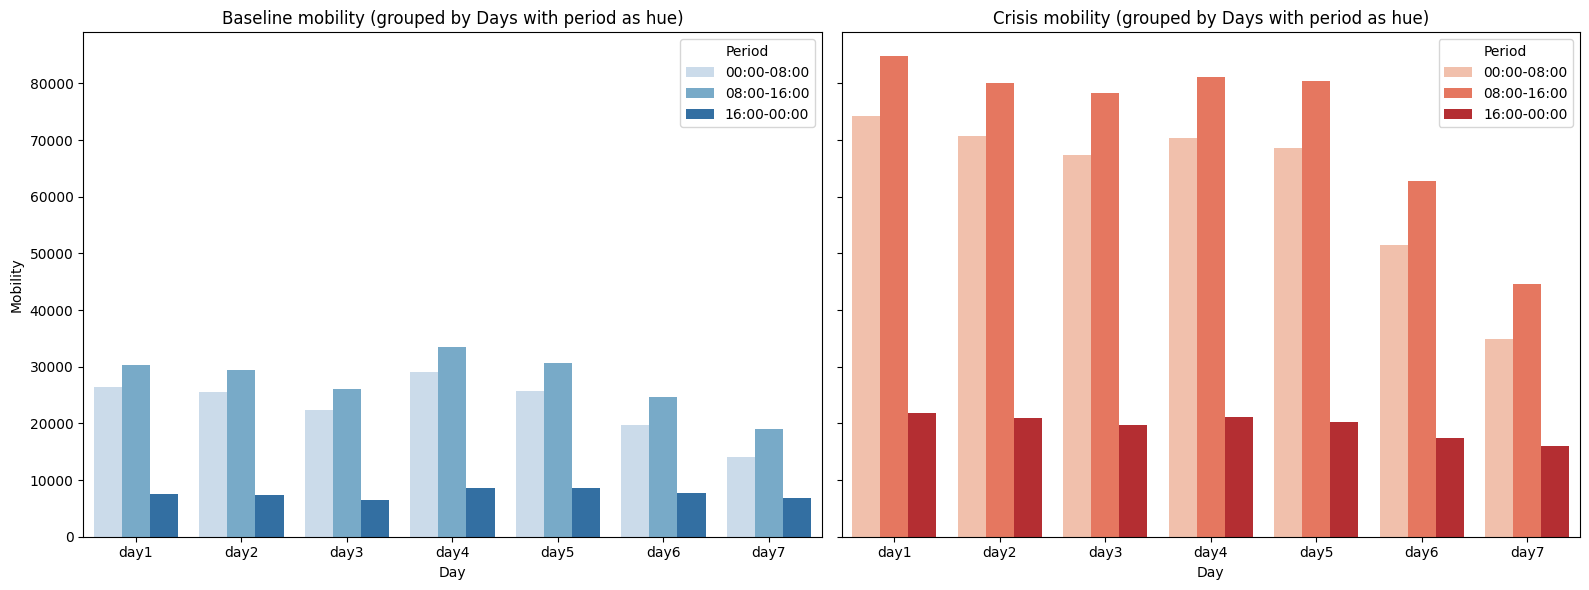

In [ ]:
# Study 1 : Evolution of Baseline vs Crisis in function of days

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# F1 : Baseline mobility
sns.barplot(x='Day', y='Baseline', hue='Period', data=time_window_summary, palette='Blues', ax=axes[0])
axes[0].set_title("Baseline mobility (grouped by Days with period as hue)")
axes[0].set_xlabel("Day")
axes[0].set_ylabel("Mobility")
axes[0].legend(title="Period")

# F2 : Crisis mobility
sns.barplot(x='Day', y='Crisis', hue='Period', data=time_window_summary, palette='Reds', ax=axes[1])
axes[1].set_title("Crisis mobility (grouped by Days with period as hue)")
axes[1].set_xlabel("Day")
axes[1].set_ylabel("")
axes[1].legend(title="Period")

plt.tight_layout()
plt.show()

- Overall we can notice that crisis mobility is **significantly higher** than baseline, indicating an unexpected **increase** in movement during the first days of crisis.  
- We got mainly some mobility peaks during **08:00–16:00** across all days, with the lowest values in **16:00–00:00** in general.  
- The crisis mobility shows a **gradual decline** from day 1 to day 7, suggesting a better adherence for the population to policies.  
- **Conclusion**: The expected travel reduction did not occur initially, with mobility during the crisis period exceeding pre-crisis levels significantly.  

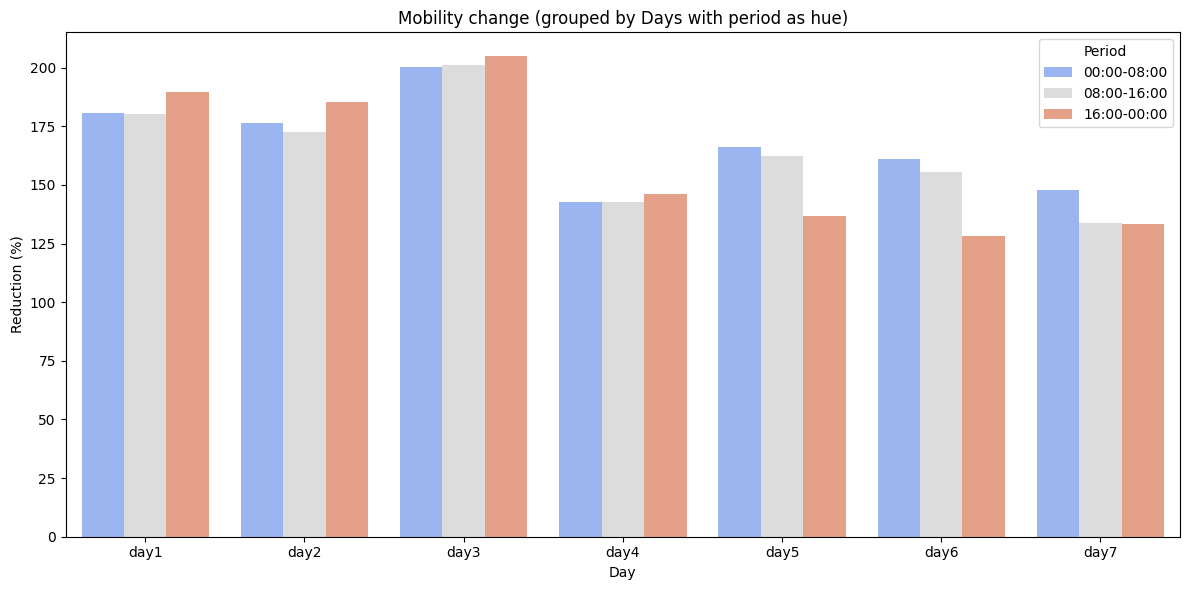

In [ ]:
# F3 : Mobility change % on days

plt.figure(figsize=(12, 6))
sns.barplot(x='Day', y='Change (%)', hue='Period', data=time_window_summary, palette='coolwarm')
plt.title("Mobility change (grouped by Days with period as hue)")
plt.xlabel("Day")
plt.ylabel("Reduction (%)")
plt.legend(title="Period")
plt.tight_layout()
plt.show()

 The observed number of people moving during the crisis was higher than normal, indicating increased mobility. After the first 3 days, it showed a gradual decline over time. Evening periods remained a weak point, with lower reductions compared to other time periods.

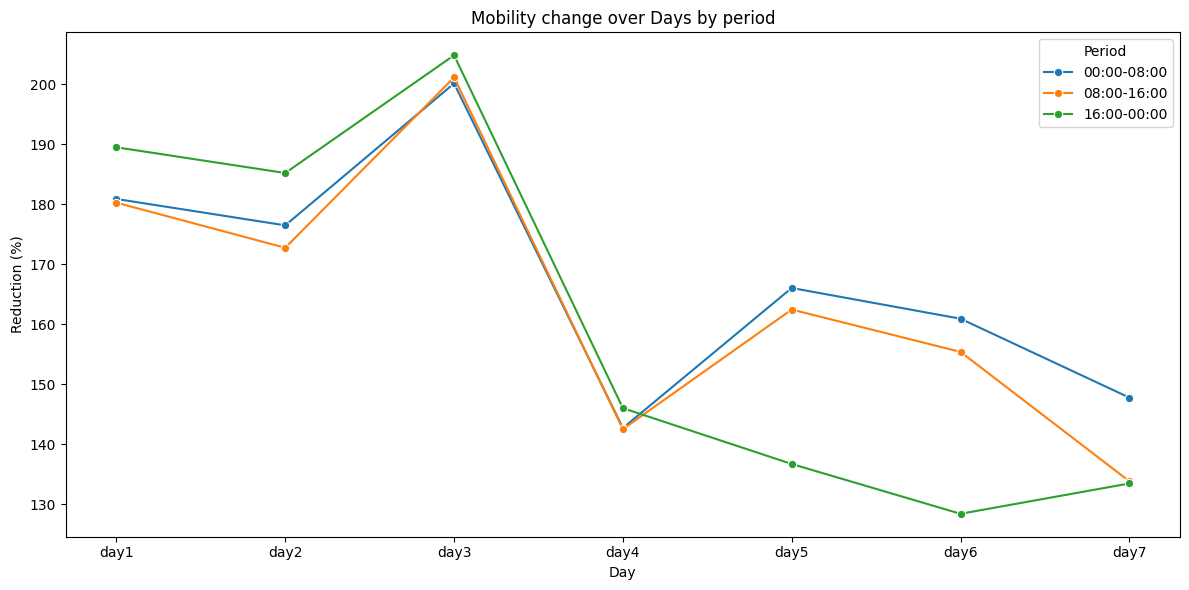

In [ ]:
# F4: Line Plot for Comparison
plt.figure(figsize=(12, 6))
sns.lineplot(x='Day', y='Change (%)', hue='Period', data=time_window_summary, marker='o')
plt.title("Mobility change over Days by period")
plt.xlabel("Day")
plt.ylabel("Reduction (%)")
plt.legend(title="Period")
plt.tight_layout()
plt.show()

In [ ]:
# Extract Day and Period from the time_window column
time_reduction['Day'] = time_reduction['time_window'].apply(lambda x: x.split('_')[0])  # e.g., day1
time_reduction['Period'] = time_reduction['time_window'].apply(lambda x: x.split('_')[1])  # e.g., 0000, 0800, 1600
time_reduction.head()

,time_window,Baseline,Crisis,Change (%),Change Type,Day,Period
0,day1_0000,26461.183267,74316,180.849119,Increase,day1,0000
1,day1_0800,30246.862115,84761,180.230722,Increase,day1,0800
2,day1_1600,7567.933333,21906,189.458152,Increase,day1,1600
3,day2_0000,25566.409824,70679,176.452582,Increase,day2,0000
4,day2_0800,29369.849637,80097,172.718454,Increase,day2,0800
5,day2_1600,7373.400000,21027,185.173733,Increase,day2,1600
6,day3_0000,22432.973946,67321,200.098418,Increase,day3,0000
7,day3_0800,25983.077610,78234,201.095972,Increase,day3,0800
8,day3_1600,6462.821107,19698,204.789498,Increase,day3,1600
9,day4_0000,29007.305815,70398,142.690584,Increase,day4,0000


## Conclusion

From the table, there are no reductions observed, as all **Change (%)** values are positive. This indicates that mobility increased significantly during the crisis period compared to the baseline across all days and time periods. The increase ranges between **142% and 204%**, meaning mobility surged by over **1.4x to 2x** the pre-crisis levels.

Mobility peaked on **day 3**, after which a slight decline in the mobility increase begins on **day 4**. Daytime and evening periods consistently show larger increases compared to mornings, reflecting higher activity during these hours.

This trend highlights a clear **non-compliance with social distancing measures** and creating even more mobility due to the situation illustrated by persistent movement across the city during the crisis.

# II - Comparison of Areas in the data

## Areas analysis

In [ ]:
time_reduction

,time_window,Baseline,Crisis,Change (%),Change Type,Day,Period,Cluster
0,day1_0000,26461.183267,74316,180.849119,Increase,day1,0000,2
1,day1_0800,30246.862115,84761,180.230722,Increase,day1,0800,2
2,day1_1600,7567.933333,21906,189.458152,Increase,day1,1600,1
3,day2_0000,25566.409824,70679,176.452582,Increase,day2,0000,2
4,day2_0800,29369.849637,80097,172.718454,Increase,day2,0800,2
5,day2_1600,7373.400000,21027,185.173733,Increase,day2,1600,1
6,day3_0000,22432.973946,67321,200.098418,Increase,day3,0000,0
7,day3_0800,25983.077610,78234,201.095972,Increase,day3,0800,0
8,day3_1600,6462.821107,19698,204.789498,Increase,day3,1600,1
9,day4_0000,29007.305815,70398,142.690584,Increase,day4,0000,2


In [ ]:
# Assuming df contains x, y, and other relevant columns
# Merge the spatial and additional information from df into time_reduction
time_reduction_full = time_reduction.merge(
    df[['time_window', 'x0', 'y0', 'x1', 'y1']],
    on='time_window',
    how='left'
)

cluster_data = time_reduction_full[['Baseline', 'Crisis', 'Change (%)', 'x0', 'y0', 'x1', 'y1']].copy()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)
kmeans = KMeans(n_clusters=3, random_state=42)
time_reduction_full['Cluster'] = kmeans.fit_predict(scaled_data)



route_data = time_reduction_full[['x0', 'y0', 'x1', 'y1']].copy()
scaler = StandardScaler()
scaled_routes = scaler.fit_transform(route_data)
kmeans = KMeans(n_clusters=4, random_state=42)
time_reduction_full['Route Cluster'] = kmeans.fit_predict(scaled_routes)

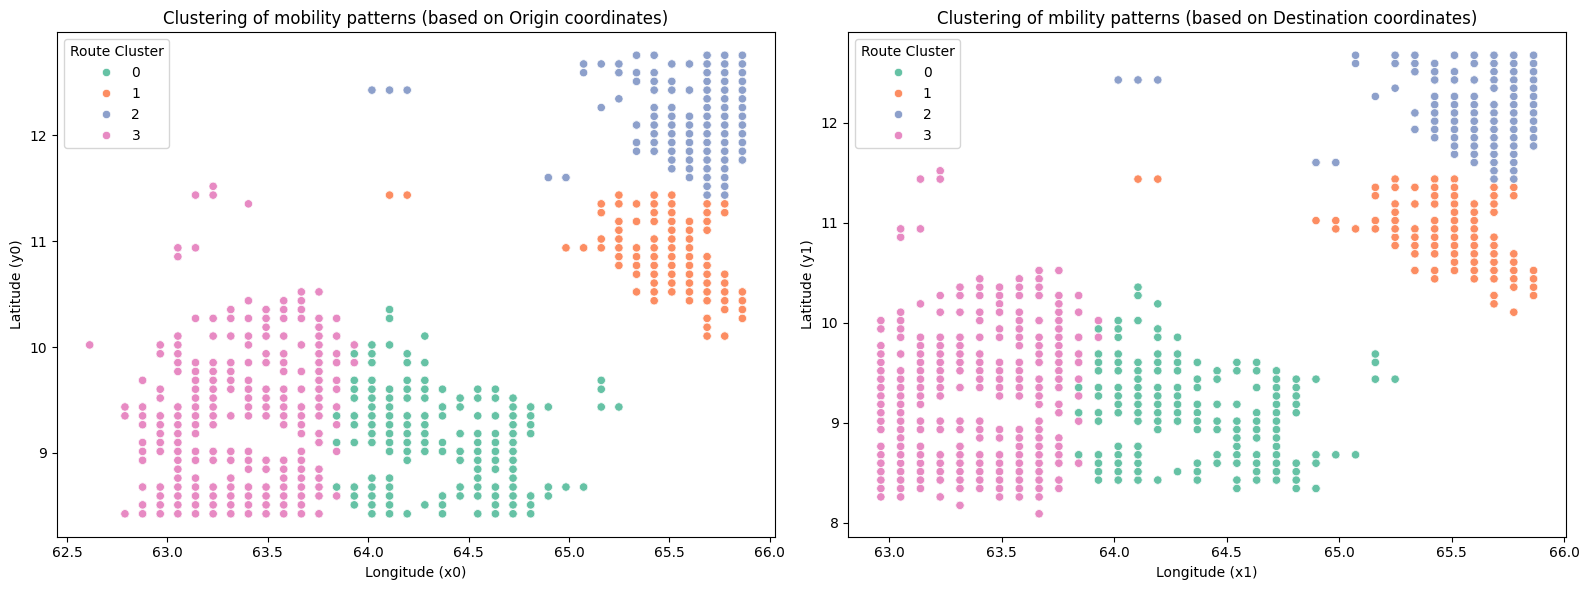

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F5 1: Origin Clusters
sns.scatterplot(
    ax=axes[0], x='x0', y='y0', hue='Route Cluster', palette='Set2',
    data=time_reduction_full, legend='full'
)
axes[0].set_title("Clustering of mobility patterns (based on Origin coordinates)")
axes[0].set_xlabel("Longitude (x0)")
axes[0].set_ylabel("Latitude (y0)")

# F6: Destination Clusters
sns.scatterplot(
    ax=axes[1], x='x1', y='y1', hue='Route Cluster', palette='Set2',
    data=time_reduction_full, legend='full'
)
axes[1].set_title("Clustering of mbility patterns (based on Destination coordinates)")
axes[1].set_xlabel("Longitude (x1)")
axes[1].set_ylabel("Latitude (y1)")

plt.tight_layout()
plt.show()

The clustering based on origin and destination coordinates reveals:

*   Clusters 1 and 2 represent high-mobility zones acting as hubs for movement.
*   Cluster 3 shows better compliance with mobility restrictions, with dispersed and lower movement.


Possible vulnerabilities :
*   Areas in Clusters 1 and 2 are unable to reduce mobility, indicating potential non-compliance with restrictions or critical zones requiring intervention.


# III - Further analysis

## Identification of Mobility patterns

We will analyze mobility patterns over the 7-day period to identify peaks and drops in movement.

In [ ]:
time_series_data = time_reduction_full.copy()
time_series_data['Day'] = time_series_data['time_window'].apply(lambda x: x.split('_')[0])
time_series_data['Period'] = time_series_data['time_window'].apply(lambda x: x.split('_')[1])


period_mapping = {'0000': '00:00–08:00', '0800': '08:00–16:00', '1600': '16:00–00:00'}
time_series_data['Period'] = time_series_data['Period'].map(period_mapping)




grouped_trends = time_series_data.groupby(['Day', 'Period']).agg({
    'Baseline': 'sum',
    'Crisis': 'sum',
    'Change (%)': 'mean'
}).reset_index()

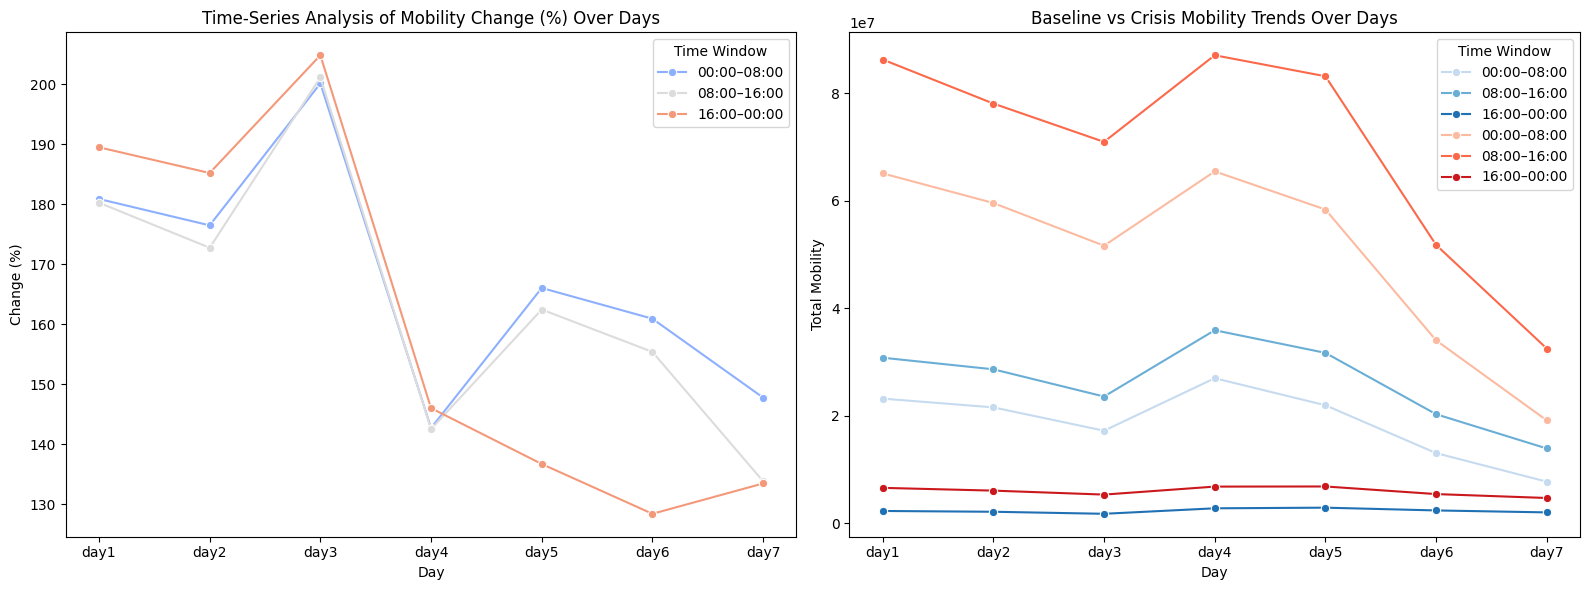

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F7 : Change (%) Over Days
sns.lineplot(
    ax=axes[0], x='Day', y='Change (%)', hue='Period',
    data=grouped_trends, marker='o', palette='coolwarm'
)
axes[0].set_title("Time-Series Analysis of Mobility Change (%) Over Days")
axes[0].set_xlabel("Day")
axes[0].set_ylabel("Change (%)")
axes[0].legend(title="Time Window")

# F8 : Baseline vs Crisis Mobility
sns.lineplot(
    ax=axes[1], x='Day', y='Baseline', hue='Period',
    data=grouped_trends, style="Period", marker='o', dashes=False, palette='Blues'
)
sns.lineplot(
    ax=axes[1], x='Day', y='Crisis', hue='Period',
    data=grouped_trends, style="Period", marker='o', dashes=False, palette='Reds'
)
axes[1].set_title("Baseline vs Crisis Mobility Trends Over Days")
axes[1].set_xlabel("Day")
axes[1].set_ylabel("Total Mobility")
axes[1].legend(title="Time Window")

plt.tight_layout()
plt.show()

We notice persistent mobility increases during the crisis, especially during daytime hours. As remark : A peak on day 4 and a notable reduction on days 6 and 7, suggesting evolving behavior or policy impacts.

Daytime activity (08:00–16:00) remains the most critical period for intervention to control mobility.

## Areas Vulnerabilities identification

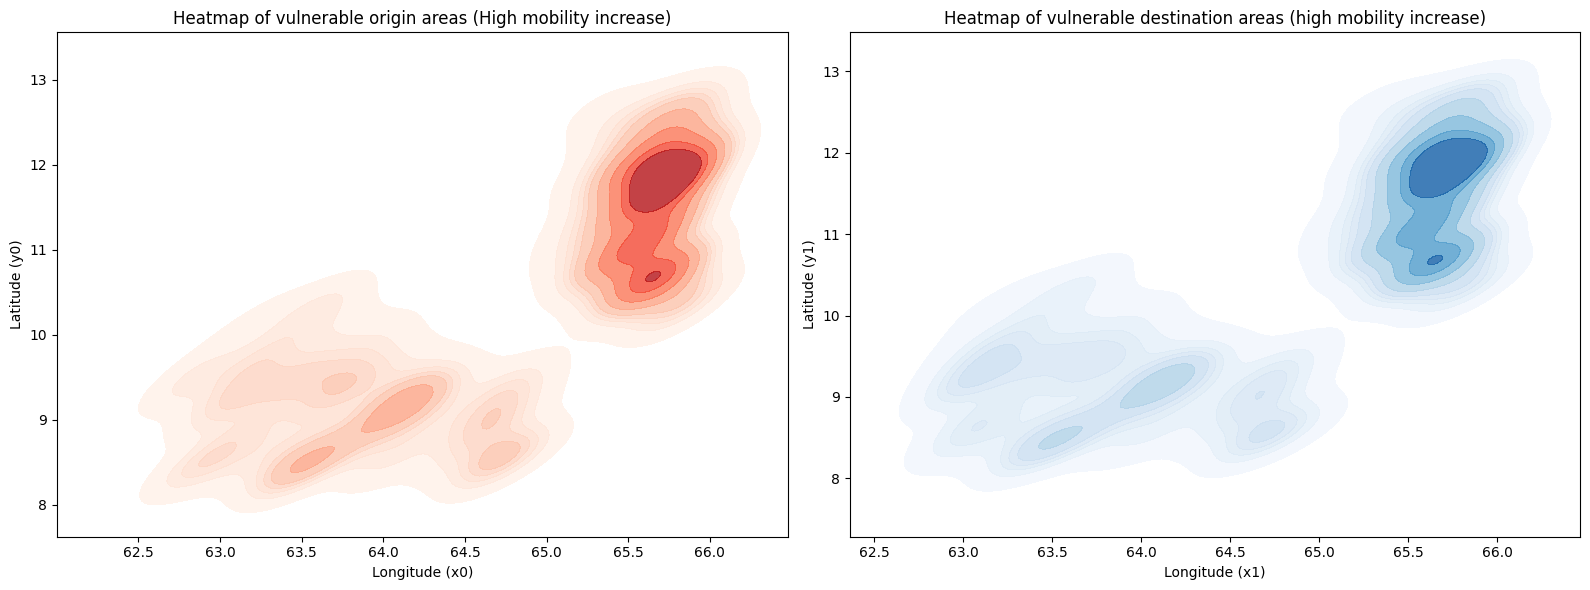

In [ ]:
vulnerable_data = time_reduction_full[time_reduction_full['Change (%)'] > 0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F9: Heatmap for origin points
sns.kdeplot(
    ax=axes[0], x=vulnerable_data['x0'], y=vulnerable_data['y0'],
    cmap="Reds", fill=True, alpha=0.8
)
axes[0].set_title("Heatmap of vulnerable origin areas (High mobility increase)")
axes[0].set_xlabel("Longitude (x0)")
axes[0].set_ylabel("Latitude (y0)")

# F10: Heatmap for destination points
sns.kdeplot(
    ax=axes[1], x=vulnerable_data['x1'], y=vulnerable_data['y1'],
    cmap="Blues", fill=True, alpha=0.8
)
axes[1].set_title("Heatmap of vulnerable destination areas (high mobility increase)")
axes[1].set_xlabel("Longitude (x1)")
axes[1].set_ylabel("Latitude (y1)")


plt.tight_layout()
plt.show()

## Conclusion

We can clearly see that the upper-right region (Longitude ~65.5 to 66.0, Latitude ~12.5 to 13.0) is the most vulnerable, showing persistent high mobility increases. A smaller vulnerable area exists in the lower-left region (Longitude ~62.5 to 64.5, Latitude ~8.0 to 10.0). Further analysis would involve investigating socioeconomic factors, analyzing mobility routes between these zones, and assessing time trends to identify consistent patterns. Targeted policies and increased monitoring should focus on these regions to reduce mobility effectively.

# IV - Prediction

## Features engineering

### Distance between Origin/Destination

In [ ]:
df['Distance'] = np.sqrt((df['x1'] - df['x0'])**2 + (df['y1'] - df['y0'])**2)
print("New Feature Added: Distance")
print(df[['x0', 'y0', 'x1', 'y1', 'Distance']].head())

New Feature Added: Distance
          x0        y0         x1        y1  Distance
0  62.788086  8.425543  62.963867  8.425543  0.175781
1  62.788086  8.425543  63.227540  8.256863  0.470715
2  62.788086  8.425543  63.315430  8.172468  0.584926
3  62.788086  8.425543  63.491210  8.425543  0.703124
4  62.788086  9.350634  63.139650  9.350634  0.351564


### Time of Day as a Categorical Feature

In [ ]:
def categorize_time_window(time_window):
    if '0000' in time_window:
        return 'Night'
    elif '0800' in time_window:
        return 'Day'
    elif '1600' in time_window:
        return 'Evening'
    return 'Unknown'


df['Time_of_Day'] = df['time_window'].apply(categorize_time_window)


print("New Feature Added: Time_of_Day")
print(df[['time_window', 'Time_of_Day']].head())

New Feature Added: Time_of_Day
  time_window Time_of_Day
0   day1_0000       Night
1   day1_0000       Night
2   day1_0000       Night
3   day1_0000       Night
4   day1_0000       Night


### Day as a Numerical or Categorical Feature


In [ ]:
df['Day'] = df['time_window'].str.extract(r'day(\d+)').astype(int)

print("New Feature Added: Day")
print(df[['time_window', 'Day']].head())

New Feature Added: Day
  time_window  Day
0   day1_0000    1
1   day1_0000    1
2   day1_0000    1
3   day1_0000    1
4   day1_0000    1


### Baseline/Crisis Ratio

In [ ]:
df['Crisis_Baseline_Ratio'] = df['Crisis'] / df['Baseline']
df['Crisis_Baseline_Ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['Crisis_Baseline_Ratio'].fillna(0, inplace=True)


print("New Feature Added: Crisis_Baseline_Ratio")
print(df[['Baseline', 'Crisis', 'Crisis_Baseline_Ratio']].head())

New Feature Added: Crisis_Baseline_Ratio
    Baseline  Crisis  Crisis_Baseline_Ratio
0  14.000000      30               2.142857
1  11.000000      24               2.181818
2  16.666667      45               2.700000
3  14.000000      31               2.214286
4  13.000000      38               2.923077


<ipython-input-89-c18fa5972b78>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Crisis_Baseline_Ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-89-c18fa5972b78>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

### Reduction Category

In [ ]:
def categorize_reduction(reduction):
    if reduction >= 75:
        return 'High Reduction'
    elif reduction >= 50:
        return 'Medium Reduction'
    else:
        return 'Low Reduction'

df['Reduction_Category'] = df['Reduction (%)'].apply(categorize_reduction)

print("New Feature Added: Reduction_Category")
print(df[['Reduction (%)', 'Reduction_Category']].head())

New Feature Added: Reduction_Category
   Reduction (%) Reduction_Category
0    -114.285714      Low Reduction
1    -118.181818      Low Reduction
2    -170.000000      Low Reduction
3    -121.428571      Low Reduction
4    -192.307692      Low Reduction


----

## Implementation of the model

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


features = ['Baseline', 'Crisis', 'Distance', 'Day', 'Crisis_Baseline_Ratio']
X = pd.get_dummies(df[features + ['Time_of_Day']], drop_first=True)
y = df['Reduction (%)']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Absolute Error: 0.04
R-squared: 1.00


In [ ]:
scores = cross_val_score(model, X, y, cv=5, scoring='r2')


print(f"Cross-validated R²: {scores.mean():.2f}")

Cross-validated R²: 1.00


## Stats

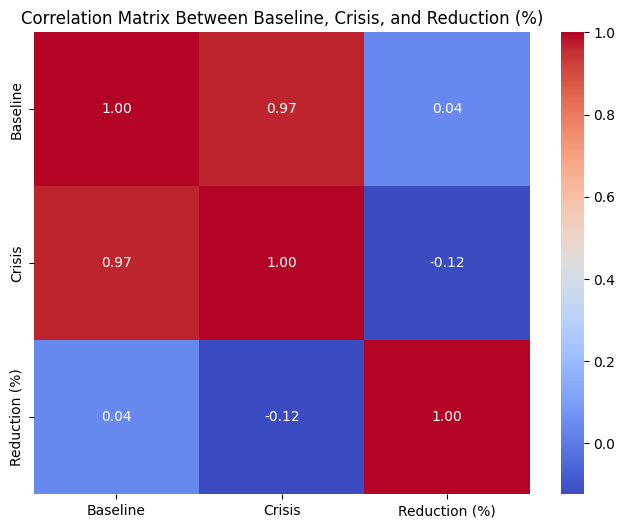

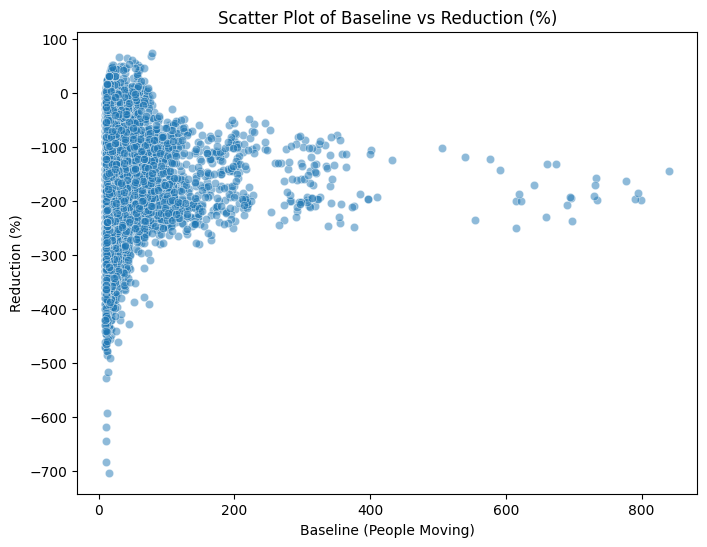

In [ ]:
correlation_matrix = df[['Baseline', 'Crisis', 'Reduction (%)']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Between Baseline, Crisis, and Reduction (%)")
plt.show()


plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Baseline', y='Reduction (%)', alpha=0.5)
plt.title("Scatter Plot of Baseline vs Reduction (%)")
plt.xlabel("Baseline (People Moving)")
plt.ylabel("Reduction (%)")
plt.show()

## Outlier detection

Number of Outliers: 72
Sample Outliers:
      index   Baseline  Crisis         x0         y0         x1         y1  \
1438  11353  13.000000      69  65.424805  11.269661  65.512695  11.352606   
1442  11357  14.000000      74  65.424805  11.849388  65.512695  11.849388   
1512  11564  10.333333      56  65.600586  10.687874  65.512695  10.604597   
1717  11941  11.000000      79  65.776370  10.437920  65.776370  10.354521   
2702   9801  15.666667      81  65.512695  11.849388  65.776370  11.849388   

     time_window  Reduction (%)  Distance Time_of_Day  Day  \
1438   day1_0800    -430.769231  0.120849         Day    1   
1442   day1_0800    -428.571429  0.087890         Day    1   
1512   day1_0800    -441.935484  0.121078         Day    1   
1717   day1_0800    -618.181818  0.083399         Day    1   
2702   day2_0000    -417.021277  0.263675       Night    2   

      Crisis_Baseline_Ratio Reduction_Category  
1438               5.307692      Low Reduction  
1442               5

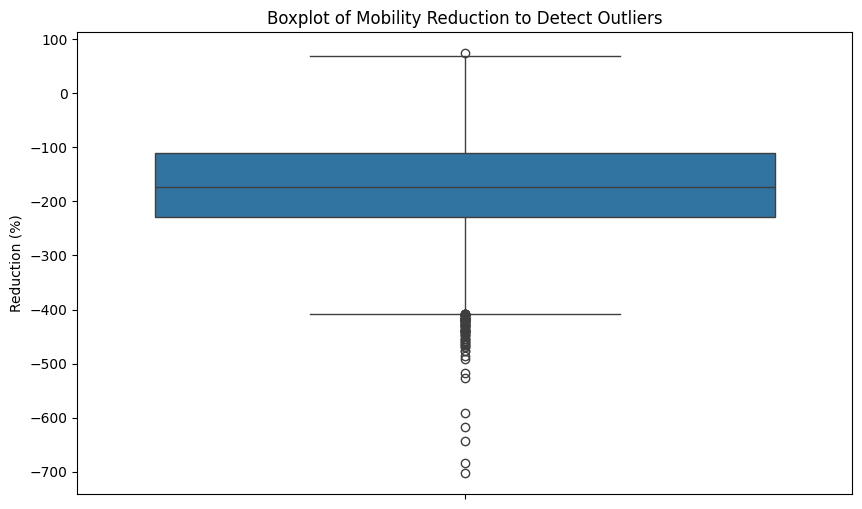

In [ ]:
Q1 = df['Reduction (%)'].quantile(0.25)
Q3 = df['Reduction (%)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


outliers = df[(df['Reduction (%)'] < lower_bound) | (df['Reduction (%)'] > upper_bound)]

print(f"Number of Outliers: {len(outliers)}")
print("Sample Outliers:")
print(outliers.head())


plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y='Reduction (%)')
plt.title("Boxplot of Mobility Reduction to Detect Outliers")
plt.show()

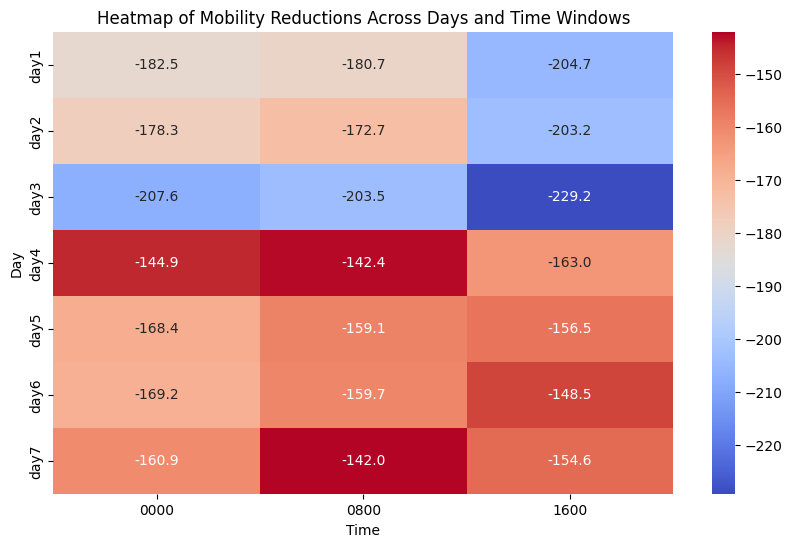

In [ ]:

time_series_data = df.groupby('time_window').agg({'Reduction (%)': 'mean'}).reset_index()


time_series_data['Day'] = time_series_data['time_window'].str.extract(r'(day\d+)')
time_series_data['Time'] = time_series_data['time_window'].str.extract(r'_(\d{4})')


pivot_time = time_series_data.pivot(index='Day', columns='Time', values='Reduction (%)')


plt.figure(figsize=(10, 6))
sns.heatmap(pivot_time, cmap="coolwarm", annot=True, fmt=".1f")
plt.title("Heatmap of Mobility Reductions Across Days and Time Windows")
plt.show()